In [1]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import numpy
from mpl_toolkits import mplot3d
from matplotlib import cm
sys.path.append("FixedStrides")
from main import *
from ast import literal_eval
results_wolant = pd.read_csv('ip32_wolant_results.csv', sep=';')
results_fst = pd.read_csv('ip32_fst_results.csv', sep=';')
results_equal_dist = pd.read_csv('ip32_equal_dist_results.csv', sep=';')
results_random = pd.read_csv('ip32_random_results.csv', sep=';')
results_random_shuffled = pd.read_csv('ip32_random_shuffled.csv', sep=';')
# results_au = pd.read_csv('ipResults_home_gtx980_australia.csv', sep=';')
# results_au_32bit = pd.read_csv('ip_32bit_au.csv', sep=';')
# results_tokyo = pd.read_csv('ip_32bit_tokyo.csv', sep=';')
# results_au_32bit.drop(results_au_32bit.columns[len(results_au_32bit.columns)-1], axis=1, inplace=True)  # delete NaN column
# results_tokyo.drop(results_tokyo.columns[len(results_tokyo.columns)-1], axis=1, inplace=True)  # delete NaN column

In [2]:
def plot_prefix_distribution(prefixes):
    lengths = utils.get_lengths(prefixes)
    plt.bar(range(1, len(lengths) + 1), lengths, align='center')
    plt.xlabel('Prefix length in bits')
    plt.ylabel('Num occurrences')
    plt.title('Prefix length distribution')
    plt.show()

In [3]:
# prefixes_au = utils.get_prefixes_from_file(file_name='FixedStrides/data/data-raw-table_australia_012016.txt')
prefixes_tokyo = utils.get_prefixes_from_file(file_name='FixedStrides/data/data-raw-table_tokyo_012016.txt')
node_counts_tokyo = utils.get_node_counts(prefixes_tokyo)

Read 576846 prefixes from file in 12.589720010757446 seconds


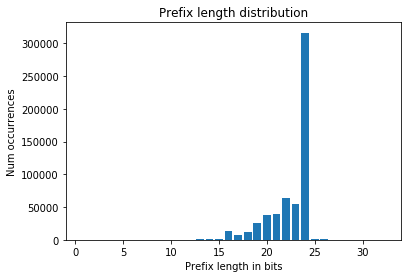

In [4]:
# plot_prefix_distribution(prefixes_au)
plot_prefix_distribution(prefixes_tokyo)

In [5]:
def get_empty_node_stats(tree_levels, strides):
    # Calculate number of empty child pointers in all nodes at each level
    # For example, if we have 100 nodes in level 1 (second level)
    # And the config for root node is 8, then it means the root node has 2^8 - 100 empty/null child pointers
    # TODO move this to utils.get_stats()
    num_empty_pointers_per_lvl = []
    percentage_empty_pointers_per_lvl = []
    total_num_pointers = 0
    for i in range(len(tree_levels) - 1):
        total_num_pointers_in_curr_lvl = tree_levels[i] * (2 ** strides[i])
        num_empty_pointers_in_curr_lvl = total_num_pointers_in_curr_lvl - tree_levels[i + 1]
        total_num_pointers += total_num_pointers_in_curr_lvl
        num_empty_pointers_per_lvl.append(num_empty_pointers_in_curr_lvl)
        percentage_empty_pointers_per_lvl.append(float(round(100 * num_empty_pointers_in_curr_lvl / total_num_pointers_in_curr_lvl, 2)))
    total_empty_pointer_percentage = float(round(100 * sum(num_empty_pointers_per_lvl) / total_num_pointers, 2))
    return num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage

# Converts string that look like this: "{1, 2, 3, 4, 5}" to list of ints: [1, 2, 3, 4 ,5]
def from_curly_bracket_str_to_list(curly_bracket_str: str):
    tmp = curly_bracket_str.replace('{', ' ').replace('}',' ').replace(',',' ').split()
    return [literal_eval(x) for x in tmp]

def append_stats(row: pd.Series, nodes: list):
    strides = from_curly_bracket_str_to_list(row['Config'])
    tree_levels = from_curly_bracket_str_to_list(row['TreeLevels'])
    num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage = get_empty_node_stats(tree_levels, strides)
    num_empty_pointers_per_lvl = str(num_empty_pointers_per_lvl)
    percentage_empty_pointers_per_lvl = str(percentage_empty_pointers_per_lvl)
    tmp, strides_nodes, cost, percent = utils.get_stats(nodes, strides, ignore_last_level=True)
    build_and_find = float(row['Build']) + float(row['Find'])
    build_and_match = float(row['Build']) + float(row['Match'])
    match_and_find = float(row['Match']) + float(row['Find'])
    return pd.Series([cost, percent, build_and_find, build_and_match, match_and_find, num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage])

def append_stats_to_df(df: pd.DataFrame):
    newcol_names = ['Cost', 'Percent', 'BuildAndFind', 'BuildAndMatch', 'MatchAndFind', 'EmptyPointerLevels', 'PercentEmptyPointerLevels', 'TotalEmptyPointerPercentage']
    # For now assume Tokyo dataset
    newcols = df.apply(lambda row: append_stats(row, node_counts_tokyo), axis=1)
    newcols.columns = newcol_names
    return df.join(newcols)

In [6]:
results_wolant = append_stats_to_df(results_wolant)
results_fst = append_stats_to_df(results_fst)
results_equal_dist = append_stats_to_df(results_equal_dist)
results_random = append_stats_to_df(results_random)
results_random_shuffled = append_stats_to_df(results_random_shuffled)

In [7]:
# results_wolant = results_wolant.sort_values('RandomMatch')
# results_wolant[['Config', 'Match', 'RandomMatch', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

# results_fst = results_fst.sort_values('RandomMatch')
# results_fst[['Config', 'Match', 'RandomMatch', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

# results_equal_dist = results_equal_dist.sort_values('Match')
# results_equal_dist[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

In [8]:
results_wolant = results_wolant.sort_values('RandomMatch')
results_wolant[['Config', 'TreeMemoryUniqueOnly', 'MaxItemsPerLevel', 'PercentEmptyPointerLevels', 'RandomMatch', 'Match', 'Find', 'ItemsPerLevel', 'Build', 'EmptyPointerLevels']]

,Config,TreeMemoryUniqueOnly,MaxItemsPerLevel,PercentEmptyPointerLevels,RandomMatch,Match,Find,ItemsPerLevel,Build,EmptyPointerLevels
11,"{8, 2, 2, 2, 2, 2, 2, 2, 2, 8}",2946048,371291,"[83.98, 57.32, 40.71, 38.7, 41.95, 48.92, 34.2...",0.535264,1.39802,0,"{16, 49, 365, 1522, 14744, 20015, 63408, 10387...",30.9843,"[215, 94, 114, 257, 683, 1849, 2646, 2918, 68017]"
12,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3551560,316089,"[0.0, 0.0, 0.0, 12.5, 10.71, 36.0, 40.62, 46.0...",0.565920,5.86992,0,"{0, 0, 0, 0, 0, 0, 0, 16, 13, 36, 100, 265, 50...",79.5265,"[0, 0, 0, 2, 3, 18, 26, 35, 30, 34, 33, 48, 72..."
7,"{8, 4, 4, 2, 2, 2, 2, 8}",2944456,371291,"[83.98, 74.7, 64.42, 48.92, 34.26, 14.37, 97.76]",0.575520,1.57565,0,"{16, 414, 16266, 20015, 63408, 103872, 371291,...",28.6153,"[215, 490, 1711, 1849, 2646, 2918, 68017]"
2,"{8, 4, 4, 4, 4, 8}",2769680,475163,"[83.98, 74.7, 64.42, 66.42, 98.08]",0.611552,1.61504,0,"{16, 414, 16266, 83423, 475163, 1564, }",21.5679,"[215, 490, 1711, 10042, 79689]"
10,"{4, 5, 4, 5, 6, 4, 2, 2}",2972080,538571,"[12.5, 88.39, 68.75, 76.79, 98.74, 99.82, 88.59]",1.030400,3.92195,0,"{0, 29, 907, 35775, 538571, 1518, 25, 21, }",25.5752,"[2, 396, 572, 6389, 122025, 24898, 163]"
9,"{4, 4, 4, 4, 8, 8}",3311312,558586,"[12.5, 81.7, 74.7, 64.42, 99.36]",1.461860,10.80240,0,"{0, 16, 414, 16266, 558586, 1564, }",20.8556,"[2, 183, 490, 1711, 240361]"
6,"{8, 8, 4, 2, 2, 8}",2970800,371291,"[83.98, 91.0, 66.42, 14.37, 97.76]",8.254430,0.96832,0,"{16, 16680, 83423, 103872, 371291, 1564, }",21.3727,"[215, 9551, 10042, 2918, 68017]"
3,"{8, 8, 2, 2, 2, 2, 8}",2971824,371291,"[83.98, 91.0, 48.92, 34.26, 14.37, 97.76]",8.323230,1.01786,0,"{16, 16680, 20015, 63408, 103872, 371291, 1564, }",23.9701,"[215, 9551, 1849, 2646, 2918, 68017]"
5,"{8, 8, 4, 4, 8}",2797048,475163,"[83.98, 91.0, 66.42, 98.08]",8.347870,1.57658,0,"{16, 16680, 83423, 475163, 1564, }",18.6101,"[215, 9551, 10042, 79689]"
8,"{8, 8, 16}",2358400,560150,"[83.98, 91.0]",9.194270,10.59550,0,"{16, 16680, 560150, }",13.8241,"[215, 9551]"


In [9]:
results_fst = results_fst.sort_values('RandomMatch')
results_fst[['Config', 'TreeMemoryUniqueOnly', 'RandomMatch', 'Match', 'Find', 'ItemsPerLevel', 'MaxItemsPerLevel', 'Percent', 'PercentEmptyPointerLevels', 'Build', 'TreeLevels', 'EmptyPointerLevels']]

,Config,TreeMemoryUniqueOnly,RandomMatch,Match,Find,ItemsPerLevel,MaxItemsPerLevel,Percent,PercentEmptyPointerLevels,Build,TreeLevels,EmptyPointerLevels
12,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3551560,0.564992,2.279680,0,"{0, 0, 0, 0, 0, 0, 0, 16, 13, 36, 100, 265, 50...",316089,100.000000,"[0.0, 0.0, 0.0, 12.5, 10.71, 36.0, 40.62, 46.0...",80.3222,"{1,2,4,8,14,25,32,38,41,52,70,107,166,260,407,...","[0, 0, 0, 2, 3, 18, 26, 35, 30, 34, 33, 48, 72..."
10,"{8, 4, 4, 2, 2, 2, 1, 1, 2, 1, 2, 3}",3379696,0.572192,1.051650,0,"{16, 414, 16266, 20015, 63408, 103872, 55202, ...",316089,90.136753,"[83.98, 74.7, 64.42, 48.92, 34.26, 14.37, 2.9,...",34.2293,"{1,41,166,945,1931,5078,17394,33779,1559,442,6...","[215, 490, 1711, 1849, 2646, 2918, 1009, 65999..."
11,"{8, 4, 4, 2, 2, 2, 1, 1, 1, 1, 1, 2, 3}",3383536,0.594432,1.115330,0,"{16, 414, 16266, 20015, 63408, 103872, 55202, ...",316089,90.109119,"[83.98, 74.7, 64.42, 48.92, 34.26, 14.37, 2.9,...",39.3551,"{1,41,166,945,1931,5078,17394,33779,1559,1017,...","[215, 490, 1711, 1849, 2646, 2918, 1009, 65999..."
0,"{3, 5, 4, 4, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2}",2983040,0.751616,1.415390,0,"{0, 16, 414, 16266, 20015, 63408, 103872, 3712...",371291,84.788536,"[0.0, 83.98, 74.7, 64.42, 48.92, 34.26, 14.37,...",51.7679,"{1,8,41,166,945,1931,5078,17394,1559,1017,442,...","[0, 215, 490, 1711, 1849, 2646, 2918, 68017, 2..."
7,"{12, 4, 2, 2, 2, 1, 1, 3, 5}",3408608,1.527740,1.046620,0,"{430, 16266, 20015, 63408, 103872, 55202, 3160...",316089,90.352937,"[95.95, 64.42, 48.92, 34.26, 14.37, 2.9, 97.69...",29.3192,"{1,166,945,1931,5078,17394,33779,1559,63,}","[3930, 1711, 1849, 2646, 2918, 1009, 65999, 12..."
8,"{12, 4, 2, 2, 2, 1, 1, 2, 2, 4}",3394176,1.533120,0.997952,0,"{430, 16266, 20015, 63408, 103872, 55202, 3160...",316089,90.201315,"[95.95, 64.42, 48.92, 34.26, 14.37, 2.9, 97.69...",38.1435,"{1,166,945,1931,5078,17394,33779,1559,442,46,}","[3930, 1711, 1849, 2646, 2918, 1009, 65999, 57..."
9,"{12, 4, 2, 2, 2, 1, 1, 2, 1, 2, 3}",3392064,1.536060,1.029730,0,"{430, 16266, 20015, 63408, 103872, 55202, 3160...",316089,90.168056,"[95.95, 64.42, 48.92, 34.26, 14.37, 2.9, 97.69...",36.4509,"{1,166,945,1931,5078,17394,33779,1559,442,63,30,}","[3930, 1711, 1849, 2646, 2918, 1009, 65999, 57..."
6,"{13, 4, 3, 2, 1, 1, 3, 5}",3415496,2.479740,0.883232,0,"{936, 23171, 76012, 103872, 55202, 316089, 150...",316089,91.418692,"[96.83, 68.27, 51.91, 14.37, 2.9, 97.69, 99.49]",31.8433,"{1,260,1320,5078,17394,33779,1559,63,}","[7932, 2840, 5482, 2918, 1009, 65999, 12409]"
4,"{17, 3, 2, 1, 1, 8}",3837824,45.406100,0.931712,0,"{24107, 76012, 103872, 55202, 316089, 1564, }",316089,93.501291,"[98.99, 51.91, 14.37, 2.9, 97.69]",23.3862,"{1,1320,5078,17394,33779,1559,}","[129752, 5482, 2918, 1009, 65999]"
5,"{17, 3, 2, 1, 1, 3, 5}",3888256,45.719600,0.936736,0,"{24107, 76012, 103872, 55202, 316089, 1501, 63, }",316089,93.986481,"[98.99, 51.91, 14.37, 2.9, 97.69, 99.49]",24.3634,"{1,1320,5078,17394,33779,1559,63,}","[129752, 5482, 2918, 1009, 65999, 12409]"


In [10]:
results_equal_dist = results_equal_dist.sort_values('RandomMatch')
results_equal_dist[['Config', 'RandomMatch', 'Match', 'Find', 'ItemsPerLevel', 'MaxItemsPerLevel', 'TreeMemoryUniqueOnly', 'Percent', 'PercentEmptyPointerLevels', 'Build', 'TreeLevels', 'EmptyPointerLevels']]

,Config,RandomMatch,Match,Find,ItemsPerLevel,MaxItemsPerLevel,TreeMemoryUniqueOnly,Percent,PercentEmptyPointerLevels,Build,TreeLevels,EmptyPointerLevels
4,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.563232,3.000030,0,"{0, 0, 0, 0, 0, 0, 0, 16, 13, 36, 100, 265, 50...",316089,3551560,100.000000,"[0.0, 0.0, 0.0, 12.5, 10.71, 36.0, 40.62, 46.0...",79.8705,"{1,2,4,8,14,25,32,38,41,52,70,107,166,260,407,...","[0, 0, 0, 2, 3, 18, 26, 35, 30, 34, 33, 48, 72..."
3,"{20, 1, 1, 1, 1, 8}",197.644000,0.859328,0,"{100119, 40081, 63791, 55202, 316089, 1564, }",316089,7561408,136.816479,"[99.52, 9.54, 5.33, 2.9, 97.69]",22.9425,"{1,5078,9187,17394,33779,1559,}","[1043498, 969, 980, 1009, 65999]"
2,"{20, 2, 1, 1, 8}",198.949000,0.751232,0,"{100119, 103872, 55202, 316089, 1564, }",316089,7455000,132.745921,"[99.52, 14.37, 2.9, 97.69]",19.9324,"{1,5078,17394,33779,1559,}","[1043498, 2918, 1009, 65999]"
1,"{21, 2, 1, 8}",288.889000,0.695360,0,"{140200, 118993, 316089, 1564, }",316089,11469576,185.513142,"[99.56, 8.08, 97.69]",20.5227,"{1,9187,33779,1559,}","[2087965, 2969, 65999]"
0,"{22, 1, 9}",447.414000,29.614500,0,"{203991, 55202, 317653, }",317653,19633256,275.912299,"[99.59, 2.9]",17.4962,"{1,17394,33779,}","[4176910, 1009]"


In [11]:
results_random = results_random.sort_values('RandomMatch')
results_random[['Config', 'RandomMatch', 'Match', 'ItemsPerLevel', 'MaxItemsPerLevel', 'TreeMemoryUniqueOnly', 'Percent', 'PercentEmptyPointerLevels', 'Build', 'TreeLevels', 'EmptyPointerLevels']]

,Config,RandomMatch,Match,ItemsPerLevel,MaxItemsPerLevel,TreeMemoryUniqueOnly,Percent,PercentEmptyPointerLevels,Build,TreeLevels,EmptyPointerLevels
507,"{4, 7, 2, 3, 5, 2, 2, 7}",0.408768,0.995168,"{0, 165, 771, 15760, 123504, 118993, 316636, 1...",316636,3495856,127.013636,"[12.5, 94.03, 39.25, 54.57, 69.62, 8.08, 99.25]",29.2724,"{1,14,107,260,945,9187,33779,1017,}","[2, 1685, 168, 1135, 21053, 2969, 134099]"
790,"{8, 3, 1, 6, 2, 1, 2, 1, 3, 5}",0.437856,1.156900,"{16, 149, 265, 36281, 63408, 40081, 118993, 31...",316089,3307392,94.006779,"[83.98, 67.38, 22.43, 81.82, 34.26, 9.54, 8.08...",32.3344,"{1,41,107,166,1931,5078,9187,33779,1559,63,}","[215, 221, 48, 8693, 2646, 969, 2969, 65999, 1..."
396,"{4, 7, 5, 5, 1, 10}",0.453536,1.036220,"{0, 165, 16531, 123504, 63791, 372855, }",372855,2744184,61.197519,"[12.5, 94.03, 72.4, 69.62, 5.33]",23.7629,"{1,14,107,945,9187,17394,}","[2, 1685, 2479, 21053, 980]"
602,"{7, 2, 1, 1, 3, 2, 1, 6, 9}",0.454368,1.361120,"{0, 29, 36, 100, 1787, 14744, 7411, 235086, 31...",317653,2959000,140.575112,"[70.31, 65.79, 32.69, 23.57, 52.45, 41.95, 30....",29.7993,"{1,38,52,70,107,407,945,1320,33779,}","[90, 100, 34, 33, 449, 683, 570, 50701]"
725,"{2, 7, 2, 2, 1, 4, 5, 3, 3, 3}",0.466688,1.309700,"{0, 29, 136, 771, 1016, 34759, 222482, 317211,...",317211,3978856,214.014140,"[0.0, 89.84, 48.56, 39.25, 21.73, 70.35, 45.33...",33.7044,"{1,4,52,107,260,407,1931,33779,442,30,}","[0, 460, 101, 168, 113, 4581, 28013, 269790, 3..."
...,...,...,...,...,...,...,...,...,...,...,...
392,"{3, 4, 16, 1, 2, 6}",127.912000,100.845000,"{0, 0, 259193, 316089, 1122, 442, }",316089,12851424,469.798759,"[0.0, 70.31, 98.64, 97.69, 92.91]",24.3060,"{1,8,38,33779,1559,442,}","[0, 90, 2456589, 65999, 5794]"
91,"{9, 15, 8}",143.900000,823.114000,"{29, 575253, 1564, }",575253,9138184,805.384044,"[89.84, 99.91]",16.2372,"{1,52,1559,}","[460, 1702377]"
275,"{7, 2, 16, 1, 6}",144.114000,818.999000,"{0, 29, 575800, 575, 442, }",575800,15960720,1610.834116,"[70.31, 65.79, 99.97, 78.27]",22.7526,"{1,38,52,1017,442,}","[90, 100, 3406855, 1592]"
79,"{9, 16, 7}",144.295000,823.338000,"{29, 575800, 1017, }",575800,15949592,1610.736784,"[89.84, 99.97]",16.5750,"{1,52,1017,}","[460, 3406855]"


In [12]:
results_random_shuffled = results_random_shuffled.sort_values('RandomMatch')
results_random_shuffled[['Config', 'RandomMatch', 'Match', 'ItemsPerLevel', 'MaxItemsPerLevel', 'TreeMemoryUniqueOnly', 'Percent', 'PercentEmptyPointerLevels', 'Build', 'TreeLevels', 'EmptyPointerLevels']]

,Config,RandomMatch,Match,ItemsPerLevel,MaxItemsPerLevel,TreeMemoryUniqueOnly,Percent,PercentEmptyPointerLevels,Build,TreeLevels,EmptyPointerLevels
611,"{7, 2, 2, 5, 4, 2, 2, 5, 3}",0.392288,1.10266,"{0, 29, 136, 16531, 83423, 103872, 371291, 153...",371291,3144600,89.244630,"[70.31, 65.79, 48.56, 72.4, 66.42, 14.37, 97.7...",28.4901,"{1,38,52,107,945,5078,17394,1559,30,}","[90, 100, 101, 2479, 10042, 2918, 68017, 49858]"
957,"{8, 1, 2, 1, 2, 1, 2, 1, 4, 3, 5, 2}",0.398432,1.39478,"{16, 13, 136, 265, 1522, 1770, 20385, 12604, 1...",371838,3332536,142.009161,"[83.98, 36.59, 48.56, 22.43, 38.7, 22.48, 47.7...",36.5211,"{1,41,52,107,166,407,631,1320,1931,17394,1017,...","[215, 30, 101, 48, 257, 183, 1204, 709, 13502,..."
509,"{6, 5, 4, 1, 3, 3, 3, 7}",0.398848,1.07258,"{0, 165, 3557, 12974, 45587, 141708, 371838, 1...",371838,3191848,128.711679,"[50.0, 89.55, 63.14, 25.12, 60.3, 27.55, 99.27]",25.0088,"{1,32,107,631,945,3001,17394,1017,}","[32, 917, 1081, 317, 4559, 6614, 138135]"
428,"{3, 7, 1, 1, 5, 4, 11}",0.404640,1.19747,"{0, 65, 100, 265, 23677, 116093, 436646, }",436646,2505800,39.373264,"[0.0, 93.16, 23.57, 22.43, 75.15, 56.5]",22.6440,"{1,8,70,107,166,1320,9187,}","[0, 954, 33, 48, 3992, 11933]"
932,"{1, 4, 1, 1, 3, 1, 5, 1, 1, 3, 2, 9}",0.406080,1.15402,"{0, 0, 0, 0, 65, 100, 16531, 7411, 12604, 1034...",317653,2930320,68.479282,"[0.0, 21.88, 36.0, 40.62, 76.97, 23.57, 72.4, ...",33.2041,"{1,2,25,32,38,70,107,945,1320,1931,9187,33779,}","[0, 7, 18, 26, 234, 33, 2479, 570, 709, 6261, ..."
...,...,...,...,...,...,...,...,...,...,...,...
42,"{24, 3, 5}",1167.200000,1734.90000,"{575282, 1501, 63, }",575282,69479232,1026.208084,"[99.99, 99.49]",19.7054,"{1,1559,63,}","[16775657, 12409]"
45,"{24, 1, 7}",1167.960000,1738.00000,"{575282, 547, 1017, }",575282,69449448,1025.844191,"[99.99, 67.38]",19.3985,"{1,1559,1017,}","[16775657, 2101]"
166,"{24, 3, 3, 2}",1169.000000,2734.99000,"{575282, 1501, 42, 21, }",575282,69481456,1026.232539,"[99.99, 99.49, 95.83]",23.2200,"{1,1559,63,21,}","[16775657, 12409, 483]"
73,"{24, 7, 1}",1169.400000,1737.25000,"{575282, 1543, 21, }",575282,70227216,1033.485933,"[99.99, 99.99]",21.8148,"{1,1559,21,}","[16775657, 199531]"


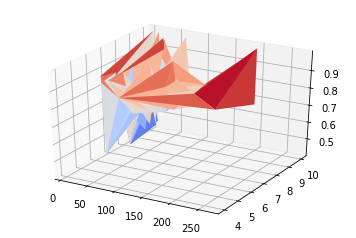

In [13]:
x = results_random['AverageNodeSize'].values
y = results_random['TreeHeight'].values
z = results_random['RandomMatch'].values
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(x[z < 1], y[z < 1], z[z < 1], cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

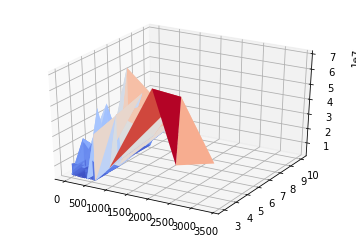

In [14]:
x = results_random['AverageNodeSize'].values
y = results_random['TreeHeight'].values
z = results_random['TreeMemoryUniqueOnly'].values
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)


,AverageNodeSize,RandomMatch
507,12.7311,0.408768
790,11.1120,0.437856
396,20.8639,0.453536
602,15.7097,0.454368
725,15.5850,0.466688
...,...,...
167,17.0397,126.585000
405,16.7737,126.884000
321,15.8361,127.416000
783,15.6022,127.426000


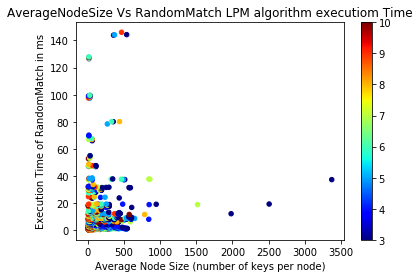

In [43]:
x = results_random['AverageNodeSize'].values
y = results_random['RandomMatch'].values
z = results_random['Depth'].values
plt.title("AverageNodeSize Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Average Node Size (number of keys per node)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

results_random = results_random.sort_values('RandomMatch')
results_random[results_random['AverageNodeSize'] < 100][['AverageNodeSize', 'RandomMatch']]

,AverageNodeSize,RandomMatch
1327,8.45481,0.413184
1292,8.05347,0.421760
1326,7.98160,0.424256
1649,8.49828,0.436544
1808,7.63731,0.437280
...,...,...
1558,8.44441,47.593000
1355,8.40161,47.767700
858,8.18070,122.264000
621,8.23289,122.372000


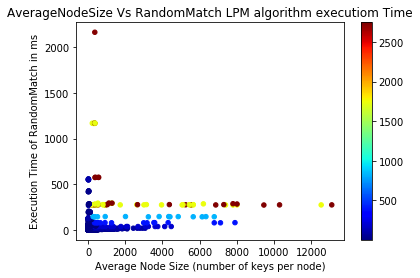

In [55]:
x = results_random_shuffled['AverageNodeSize'].values
y = results_random_shuffled['RandomMatch'].values
z = results_random_shuffled['Match'].values
plt.title("AverageNodeSize Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Average Node Size (number of keys per node)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

results_random_shuffled = results_random_shuffled.sort_values('RandomMatch')
results_random_shuffled[results_random_shuffled['AverageNodeSize'] < 9][['AverageNodeSize', 'RandomMatch']]

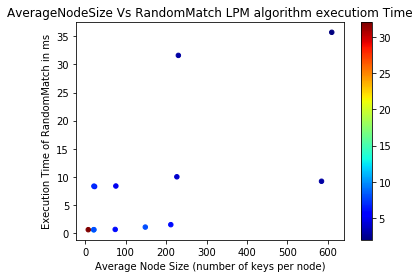

In [17]:
x = results_wolant['AverageNodeSize'].values
y = results_wolant['RandomMatch'].values
z = results_wolant['Depth'].values
plt.title("AverageNodeSize Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Average Node Size (number of keys per node)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

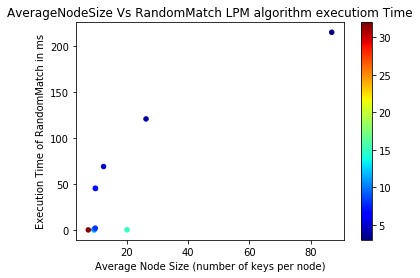

In [18]:
# Seems logarithmic in complexity, normal shape
# Conclusion- PSFT/FST algorithm give us consistency?
x = results_fst['AverageNodeSize'].values
y = results_fst['RandomMatch'].values
z = results_fst['Depth'].values
plt.title("AverageNodeSize Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Average Node Size (number of keys per node)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

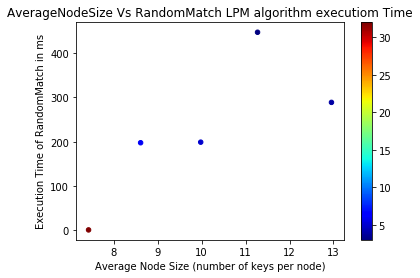

In [19]:
# Also Random
x = results_equal_dist['AverageNodeSize'].values
y = results_equal_dist['RandomMatch'].values
z = results_equal_dist['Depth'].values
plt.title("AverageNodeSize Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Average Node Size (number of keys per node)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

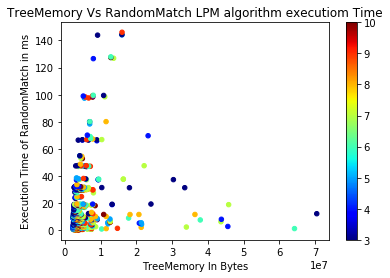

In [20]:
# Notice how fst configurations have much more normal shape
x = results_random['TreeMemoryUniqueOnly'].values
y = results_random['RandomMatch'].values
z = results_random['Depth'].values
plt.title("TreeMemory Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("TreeMemory In Bytes")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

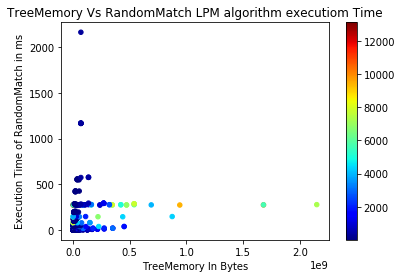

In [45]:
x = results_random_shuffled['TreeMemoryUniqueOnly'].values
y = results_random_shuffled['RandomMatch'].values
z = results_random_shuffled['AverageNodeSize'].values
plt.title("TreeMemory Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("TreeMemory In Bytes")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

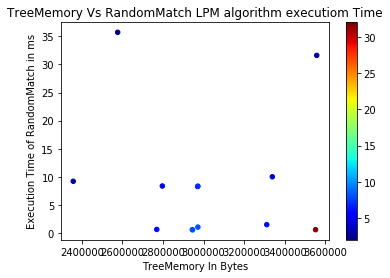

In [22]:
# Completely random
x = results_wolant['TreeMemoryUniqueOnly'].values
y = results_wolant['RandomMatch'].values
z = results_wolant['Depth'].values
plt.title("TreeMemory Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("TreeMemory In Bytes")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

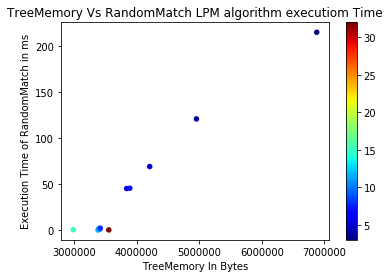

In [23]:
x = results_fst['TreeMemoryUniqueOnly'].values
y = results_fst['RandomMatch'].values
z = results_fst['Depth'].values
plt.title("TreeMemory Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("TreeMemory In Bytes")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()


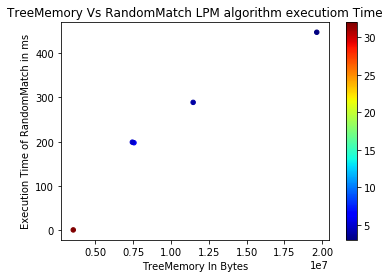

In [24]:
x = results_equal_dist['TreeMemoryUniqueOnly'].values
y = results_equal_dist['RandomMatch'].values
z = results_equal_dist['Depth'].values
plt.title("TreeMemory Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("TreeMemory In Bytes")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()


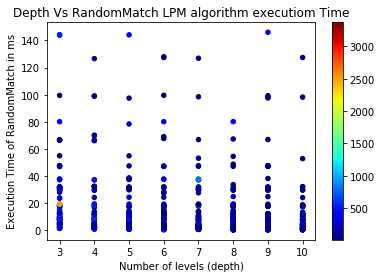

In [25]:
x = results_random['Depth'].values
y = results_random['RandomMatch'].values
z = results_random['AverageNodeSize'].values
plt.title("Depth Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Number of levels (depth)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

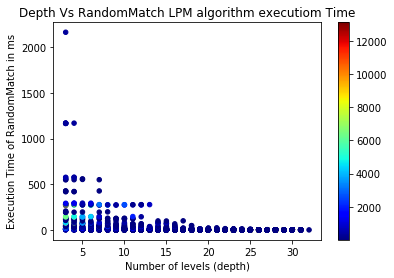

In [26]:
x = results_random_shuffled['Depth'].values
y = results_random_shuffled['RandomMatch'].values
z = results_random_shuffled['AverageNodeSize'].values
plt.title("Depth Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Number of levels (depth)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

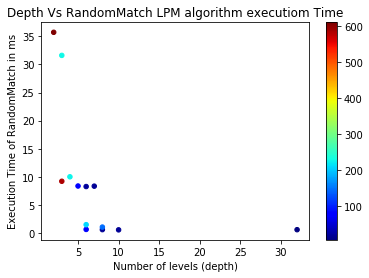

In [27]:
x = results_wolant['Depth'].values
y = results_wolant['RandomMatch'].values
z = results_wolant['AverageNodeSize'].values
plt.title("Depth Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Number of levels (depth)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

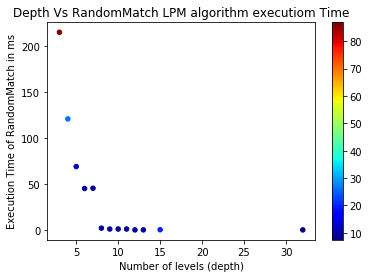

In [28]:
x = results_fst['Depth'].values
y = results_fst['RandomMatch'].values
z = results_fst['AverageNodeSize'].values
plt.title("Depth Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Number of levels (depth)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

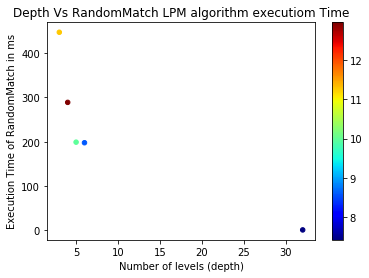

In [29]:
x = results_equal_dist['Depth'].values
y = results_equal_dist['RandomMatch'].values
z = results_equal_dist['AverageNodeSize'].values
plt.title("Depth Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Number of levels (depth)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

In [30]:
def analyze_specific_config(config_data: pd.Series):
    data_dict = {}
    strides = from_curly_bracket_str_to_list(config_data['Config'])
    tree_levels = from_curly_bracket_str_to_list(config_data['TreeLevels'])
    num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage = get_empty_node_stats(tree_levels, strides)
    data_dict['ItemsPerLevel'] = from_curly_bracket_str_to_list(config_data['ItemsPerLevel'])
    # The last level has no child pointers, append 0
    num_empty_pointers_per_lvl.append(0)
    percentage_empty_pointers_per_lvl.append(0)
    data_dict['NodePerLevel'] = tree_levels
    # This column is simply ItemsPerLevel / TreeLevels it seems
    # Can also be interpreted as the average number of key/item indexes that end in a node 
    data_dict['AverageNodeSize'] = from_curly_bracket_str_to_list(config_data['AverageNodeSizesLevels'])
    data_dict['NumEmptyPointers'] = num_empty_pointers_per_lvl
    data_dict['PercentEmptyPointerLevels'] = percentage_empty_pointers_per_lvl
    df = pd.DataFrame(data_dict)
    df = df.rename_axis('Level Index', axis=1)
    print('Data found for config: {}'.format(config_data['Config']))
    return df

In [31]:
# Same jednyki
analyze_specific_config(results_equal_dist.loc[4])

Data found for config: {1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSize,NumEmptyPointers,PercentEmptyPointerLevels
0,0,1,0.000000,0,0.00
1,0,2,0.000000,0,0.00
2,0,4,0.000000,0,0.00
3,0,8,0.000000,2,12.50
4,0,14,0.000000,3,10.71
5,0,25,0.000000,18,36.00
6,0,32,0.000000,26,40.62
7,16,38,0.421053,35,46.05
8,13,41,0.317073,30,36.59
9,36,52,0.692308,34,32.69


In [32]:
analyze_specific_config(results_equal_dist.loc[1])

Data found for config: {21, 2, 1, 8}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSize,NumEmptyPointers,PercentEmptyPointerLevels
0,140200,1,140200.00000,2087965,99.56
1,118993,9187,12.95230,2969,8.08
2,316089,33779,9.35756,65999,97.69
3,1564,1559,1.00321,0,0.00


In [33]:
# Fastest config in results_random_shuffled
analyze_specific_config(results_random_shuffled.loc[611])

Data found for config: {7, 2, 2, 5, 4, 2, 2, 5, 3}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSize,NumEmptyPointers,PercentEmptyPointerLevels
0,0,1,0.000000,90,70.31
1,29,38,0.763158,100,65.79
2,136,52,2.615380,101,48.56
3,16531,107,154.495000,2479,72.40
4,83423,945,88.278300,10042,66.42
5,103872,5078,20.455300,2918,14.37
6,371291,17394,21.345900,68017,97.76
7,1534,1559,0.983964,49858,99.94
8,30,30,1.000000,0,0.00


In [34]:
# Fast config generated from PFST algorithm
analyze_specific_config(results_fst.loc[10])

Data found for config: {8, 4, 4, 2, 2, 2, 1, 1, 2, 1, 2, 3}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSize,NumEmptyPointers,PercentEmptyPointerLevels
0,16,1,16.000000,215,83.98
1,414,41,10.097600,490,74.70
2,16266,166,97.988000,1711,64.42
3,20015,945,21.179900,1849,48.92
4,63408,1931,32.836900,2646,34.26
5,103872,5078,20.455300,2918,14.37
6,55202,17394,3.173620,1009,2.90
7,316089,33779,9.357560,65999,97.69
8,1122,1559,0.719692,5794,92.91
9,379,442,0.857466,821,92.87


In [35]:
# 10 times slower generated from PFST algorithm
analyze_specific_config(results_fst.loc[5])

Data found for config: {17, 3, 2, 1, 1, 3, 5}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSize,NumEmptyPointers,PercentEmptyPointerLevels
0,24107,1,24107.000000,129752,98.99
1,76012,1320,57.584800,5482,51.91
2,103872,5078,20.455300,2918,14.37
3,55202,17394,3.173620,1009,2.90
4,316089,33779,9.357560,65999,97.69
5,1501,1559,0.962797,12409,99.49
6,63,63,1.000000,0,0.00


In [44]:
# Config that has small average node size but is slow
# Max node size is very big
analyze_specific_config(results_random.loc[392])

Data found for config: {3, 4, 16, 1, 2, 6}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSize,NumEmptyPointers,PercentEmptyPointerLevels
0,0,1,0.000000,0,0.00
1,0,8,0.000000,90,70.31
2,259193,38,6820.870000,2456589,98.64
3,316089,33779,9.357560,65999,97.69
4,1122,1559,0.719692,5794,92.91
5,442,442,1.000000,0,0.00


In [48]:
# Config has very large average node size but isn't slower than other configs with smaller average node size
analyze_specific_config(results_random_shuffled.loc[72])

Data found for config: {1, 7, 24}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSize,NumEmptyPointers,PercentEmptyPointerLevels
0,0,1,0,0,0.00
1,16,2,8,215,83.98
2,576830,41,14069,0,0.00


In [56]:
# Config has very small average node size and is very fast
analyze_specific_config(results_random_shuffled.loc[1327])

Data found for config: {6, 3, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 7}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSize,NumEmptyPointers,PercentEmptyPointerLevels
0,0,1,0.000000,32,50.00
1,29,32,0.906250,204,79.69
2,36,52,0.692308,34,32.69
3,100,70,1.428570,33,23.57
4,265,107,2.476640,48,22.43
5,506,166,3.048190,72,21.69
6,1016,260,3.907690,113,21.73
7,14744,407,36.226000,683,41.95
8,7411,945,7.842330,570,30.16
9,12604,1320,9.548480,709,26.86


In [57]:
# Config has very small average node size but is very slow
analyze_specific_config(results_random_shuffled.loc[242])

Data found for config: {20, 1, 1, 1, 9}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSize,NumEmptyPointers,PercentEmptyPointerLevels
0,100119,1,100119.00000,1043498,99.52
1,40081,5078,7.89307,969,9.54
2,63791,9187,6.94362,980,5.33
3,55202,17394,3.17362,1009,2.90
4,317653,33779,9.40386,0,0.00


In [36]:
results_equal_dist.columns
# newcol_names = ['Cost', 'Percent', 'BuildAndFind', 'BuildAndMatch', 'MatchAndFind']
# newcols_au = results_au_32bit.apply(lambda row: append_stats(row, nodes_au), axis=1)
# newcols_tokyo = results_tokyo.apply(lambda row: append_stats(row, nodes_tokyo), axis=1)
# newcols_au.columns = newcol_names
# newcols_tokyo.columns = newcol_names
# results_au_32bit = results_au_32bit.join(newcols_au)
# results_tokyo = results_tokyo.join(newcols_tokyo)
# results_au_32bit = results_au_32bit.sort_values('MatchAndFind')
# results_au_32bit[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'RandomMatch', 'RandomSort', 'RandomSortedMatch']]
# results_tokyo = results_tokyo.sort_values('TreeMemoryUniqueOnly')
# results_tokyo[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'RandomMatch', 'RandomSort', 'RandomSortedMatch']]
# results_au_32bit = results_au_32bit.sort_values('TreeMemoryUniqueOnly')
# results_au_32bit[['Config', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'TreeLevels', 'ChildrenMemory', 'ChildrenCountsMemory', 'ScanMemory', 'PreScanMemory', 'PermuationMemory', 'LengthsMemory', 'MasksPartsMemory', 'ContainerSumMemory', 'ContainerItemsMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]
# results_tokyo = results_tokyo.sort_values('Match')
# results_tokyo[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]
# results_au_32bit = results_tokyo.sort_values('Find')
# results_au_32bit[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]
# results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Match'])
# results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Find'])
# results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Build'])
# results_tokyo['ChildrenMemory'].corr(results_au_32bit['Cost'])
# results_au_32bit['ChildrenMemory'].corr(results_au_32bit['Cost'])
# results_au_32bit['Match'].corr(results_au_32bit['Cost'])
# results_tokyo['Match'].corr(results_au_32bit['Cost'])

Index(['deviceId', 'deviceName', 'Dictionary', 'Load', 'Count', 'Sort', 'Seed',
       'Config', 'Reshape', 'Build', 'RandomCount', 'RandomMatch',
       'RandomSort', 'RandomSortedMatch', 'HitRate', 'TreeMemory',
       'TreeLevels', 'Depth', 'TreeMemoryUniqueOnly', 'ChildrenMemory',
       'ChildrenCountsMemory', 'ScanMemory', 'PreScanMemory',
       'PermuationMemory', 'LengthsMemory', 'MasksPartsMemory',
       'ContainerSumMemory', 'ContainerItemsMemory', 'ContainerStartsMemory',
       'ContainerLengthsMemory', 'AverageNodeSizesLevels', 'AverageNodeSize',
       'TreeHeight', 'NodeSizeToHeightRatio', 'ItemsPerLevel',
       'MaxItemsPerLevel', 'Find', 'Match', 'Unnamed: 38', 'Cost', 'Percent',
       'BuildAndFind', 'BuildAndMatch', 'MatchAndFind', 'EmptyPointerLevels',
       'PercentEmptyPointerLevels', 'TotalEmptyPointerPercentage'],
      dtype='object')